In [1]:
import numpy as np
import pickle
import time
from pprint import pprint

In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
pprint(provider)
device = provider.backend.ibmq_brooklyn
backend = provider.get_backend('ibmq_brooklyn')

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


In [4]:
# qubit layout
vertex_list =  [33, # 0
                32, # 1
                25, 31, # 2, 3
                34, 19, 39, # 4, 5, 6
                30, 35, 18, 45, # 7, 8, 9, 10
                20, 29, 40, 17, 46, # 11, 12, 13, 14, 15
                36, 44, 21, 28, 49, 16, 47, # 16, 17, 18, 19, 20, 21, 22
                24, 11, 37, 43, 12, 27, 50, 15, 53, # 23, 24, 25, 26, 27, 28, 29, 30, 31
                22, 48,  4, 26, 52,  8, 38, 51, 14, 60, # 32, 33, 34, 35, 36, 37, 38, 39, 40, 41
                42, 23,  3, 56,  7, 41, 54, 13, 59, # 42, 43, 44, 45, 46, 47, 48, 49, 50
                 5,  9, 61,  2, 55,  6, 64, 10, 58, # 51, 52, 53, 54, 55, 56, 57, 58, 59
                57, 62,  1, 63,  0] # 60, 61, 62, 63, 64
assert len(vertex_list) == len(set(vertex_list))
max_size = len(vertex_list) # largest graph size
shots_per_circuit = 1 << 13 # shots per one execution
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 65
shots_per_circuit: 8192


In [5]:
# indicate how to connect qubits
order = [[0,1], # 2
         [0,2],  [1,3], # 3
         [0,4],  [2,5],  [3,6], # 4
         [3,7],  [4,8],  [5,9],  [6,10], # 5
         [5,11], [7,12], [8,13], [9,14], [10,15], # 6
         [8,16], [10,17],[11,18],[12,19],[13,20],[14,21],[15,22], # 7
         [12,23],[14,24],[16,25],[17,26],[18,27],[19,28],[20,29],[21,30],[22,31], # 8
         [18,32],[20,33],[24,34],[25,35],[26,36],[27,37],[28,38],[29,39],[30,40],[31,41], # 9
         [26,42],[32,43],[34,44],[36,45],[37,46],[38,47],[39,48],[40,49],[41,50], # 10
         [34,51],[37,52],[41,53],[44,54],[45,55],[46,56],[48,57],[49,58],[50,59], # 11
         [45,60],[53,61],[54,62],[57,63],[58,64]] # 12
print("length:", len(order))

length: 64


In [6]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7, 7, 7, 7, 7,
                8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                9, 9, 9, 9, 9, 9, 9, 9, 9,
                10,10,10,10,10,10,10,10,10,
                11,11,11,11,11]
print("length:", len(qubit_depths))

length: 65


# ghz circuits

In [7]:
def ghz_state(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    qc.h(0)
    if size <= 1:
        return qc
    depth = 0
    for i, j in order:
        if depth != qubit_depths[j]:
            # qc.barrier()
            depth += 1
        qc.cx(i, j)
    return qc

In [8]:
def ghz_state_with_measurement(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    qc.compose(ghz_state(size, order, qubit_depths), qubits = range(size), inplace = True)
    qc.measure_all()
    return qc

In [9]:
ghz_qc_list = [ghz_state_with_measurement(size, order[:size-1], qubit_depths[:size]) for size in range(1, max_size+1)]

# mqc circuits

In [10]:
def mqc_state_with_measurement(size, order, qubit_depths, phi):
    qc = QuantumCircuit(size, name="mqc_" + str(size) + str(phi))
    qc.compose(ghz_state(size, order, qubit_depths), qubits = range(size), inplace = True)
    qc.barrier()
    qc.x(range(size))
    qc.rz(phi, range(size))
    qc.barrier()
    qc.compose(ghz_state(size, order, qubit_depths).inverse(), qubits = range(size), inplace = True)
    qc.measure_all()
    return qc

In [11]:
mqc_qcs_list = []
for size in range(1, max_size+1):
    mqc_qcs = []
    for j in range(size * 2 + 2):
        phi = (np.pi * j) / (size + 1)
        mqc = mqc_state_with_measurement(size, order[:size-1], qubit_depths[:size], phi)
        mqc_qcs.append(mqc)
    mqc_qcs_list.append(mqc_qcs)

In [12]:
ghz_mqc_mit_qcs_list = []
for i, size in enumerate(range(1, max_size+1)):
    meas_calibs, _ = tensored_meas_cal(mit_pattern=[[j] for j in range(size)], qr=QuantumRegister(size), circlabel='mcal')
    ghz_mqc_mit_qcs = [ghz_qc_list[i]] + mqc_qcs_list[i] + meas_calibs
    ghz_mqc_mit_qcs_list.append(ghz_mqc_mit_qcs)

In [13]:
initial_layouts_list = []
for i, size in enumerate(range(1, max_size+1)):
    initial_layouts = [vertex_list[:size] for _ in range(len(ghz_mqc_mit_qcs_list[i]))]
    initial_layouts_list.append(initial_layouts)

In [14]:
num_try = 8
print("number of try:", num_try)

number of try: 8


In [15]:
job_list_dict = dict()
for i, (ghz_mqc_mit_qcs, initial_layouts) in enumerate(zip(ghz_mqc_mit_qcs_list, initial_layouts_list)):
    job_list = []
    for _ in range(num_try):
        t1 = time.perf_counter()
        job = execute(ghz_mqc_mit_qcs,
                      backend=backend, 
                      shots=shots_per_circuit,
                      optimization_level=1,
                      initial_layout=initial_layouts)
        t2 = time.perf_counter()
        print("the job for", i + 1, "qubit circuits are casted... ( job id:", job.job_id(), ", time to create job:", t2 - t1, "s )")
        job_list.append(job.job_id())
    job_list_dict[str(i + 1)+"-qubit"] = job_list
    with open("pkls/job_list_dict.pkl", "wb") as f:
        pickle.dump(job_list_dict, f)

the job for 1 qubit circuits are casted... ( job id: 61d730669307b94d586ba85b , time to create job: 3.9128239570000005 s )
the job for 1 qubit circuits are casted... ( job id: 61d73069f2026a7cc99a1d4e , time to create job: 1.9497085900000002 s )
the job for 1 qubit circuits are casted... ( job id: 61d7306b87d4f83c7323dce3 , time to create job: 1.8346441940000062 s )
the job for 1 qubit circuits are casted... ( job id: 61d7306d8cd5fcd7d8468b7a , time to create job: 1.5339834239999988 s )
the job for 1 qubit circuits are casted... ( job id: 61d7306e87d4f888fa23dce4 , time to create job: 1.0949011550000023 s )
the job for 1 qubit circuits are casted... ( job id: 61d7306ff2026a4a8d9a1d4f , time to create job: 1.4985866549999969 s )
the job for 1 qubit circuits are casted... ( job id: 61d73071fde78bc292db97c0 , time to create job: 1.9115435209999987 s )
the job for 1 qubit circuits are casted... ( job id: 61d730732850424d9ba5ba99 , time to create job: 1.4923161039999968 s )
the job for 2 qu

the job for 9 qubit circuits are casted... ( job id: 61d730d087d4f805f523dce8 , time to create job: 1.9507020409999996 s )
the job for 9 qubit circuits are casted... ( job id: 61d730d287d4f8fba823dce9 , time to create job: 1.8535630959999878 s )
the job for 9 qubit circuits are casted... ( job id: 61d730d4fde78b86d2db97ca , time to create job: 1.6320956580000257 s )
the job for 9 qubit circuits are casted... ( job id: 61d730d587d4f88db923dcea , time to create job: 1.8339364160000002 s )
the job for 9 qubit circuits are casted... ( job id: 61d730d78adee68c0677d205 , time to create job: 1.7361218659999906 s )
the job for 10 qubit circuits are casted... ( job id: 61d730d98adee61bcc77d206 , time to create job: 2.4472633510000037 s )
the job for 10 qubit circuits are casted... ( job id: 61d730db8cd5fc0400468b84 , time to create job: 1.641175292999975 s )
the job for 10 qubit circuits are casted... ( job id: 61d730dd8df39417cd32f5df , time to create job: 1.7410665799999947 s )
the job for 10

the job for 17 qubit circuits are casted... ( job id: 61d7316f9307b9063f6ba86c , time to create job: 2.776509259000022 s )
the job for 17 qubit circuits are casted... ( job id: 61d731721234102747289944 , time to create job: 2.723227147999978 s )
the job for 18 qubit circuits are casted... ( job id: 61d731752850427ed9a5baaa , time to create job: 3.7616867049999883 s )
the job for 18 qubit circuits are casted... ( job id: 61d731788df39448c932f5ee , time to create job: 2.981239180999978 s )
the job for 18 qubit circuits are casted... ( job id: 61d7317b8cd5fc5d97468b8e , time to create job: 5.414484831999971 s )
the job for 18 qubit circuits are casted... ( job id: 61d731816d65080f4f19fd3a , time to create job: 2.8928074369999877 s )
the job for 18 qubit circuits are casted... ( job id: 61d731848df394704932f5ef , time to create job: 2.7437884789999885 s )
the job for 18 qubit circuits are casted... ( job id: 61d731878adee6317877d20f , time to create job: 4.286200081000004 s )
the job for 1

the job for 26 qubit circuits are casted... ( job id: 61d7327a9307b995836ba870 , time to create job: 4.395980217999977 s )
the job for 26 qubit circuits are casted... ( job id: 61d7327e6d6508123c19fd42 , time to create job: 4.571590227999991 s )
the job for 26 qubit circuits are casted... ( job id: 61d732832850426448a5baaf , time to create job: 5.387099062999937 s )
the job for 26 qubit circuits are casted... ( job id: 61d7328a2850420944a5bab0 , time to create job: 6.803398893000008 s )
the job for 26 qubit circuits are casted... ( job id: 61d7328f6d6508403919fd43 , time to create job: 4.503584506000038 s )
the job for 26 qubit circuits are casted... ( job id: 61d732946d650824b119fd44 , time to create job: 3.379265268999916 s )
the job for 26 qubit circuits are casted... ( job id: 61d73297fde78b2ef4db97db , time to create job: 4.23315161000005 s )
the job for 27 qubit circuits are casted... ( job id: 61d7329bfde78bcc3adb97dc , time to create job: 3.747249689 s )
the job for 27 qubit ci

the job for 34 qubit circuits are casted... ( job id: 61d7340a8cd5fc0f9e468b9e , time to create job: 8.31145187200002 s )
the job for 34 qubit circuits are casted... ( job id: 61d7341287d4f8e83523dd07 , time to create job: 6.651230709999936 s )
the job for 34 qubit circuits are casted... ( job id: 61d73418f2026aef5b9a1d73 , time to create job: 5.834095542 s )
the job for 34 qubit circuits are casted... ( job id: 61d7341f8adee6b50077d22b , time to create job: 6.346257316999981 s )
the job for 35 qubit circuits are casted... ( job id: 61d73425fde78bf1e8db97e9 , time to create job: 6.469556221000062 s )
the job for 35 qubit circuits are casted... ( job id: 61d7342b87d4f8e1a323dd0b , time to create job: 5.584120432999953 s )
the job for 35 qubit circuits are casted... ( job id: 61d734318adee6fc5a77d22d , time to create job: 5.657526033000067 s )
the job for 35 qubit circuits are casted... ( job id: 61d734379307b906806ba87d , time to create job: 10.026876129999891 s )
the job for 35 qubit c

the job for 42 qubit circuits are casted... ( job id: 61d7360487d4f8228c23dd17 , time to create job: 9.222461254000109 s )
the job for 43 qubit circuits are casted... ( job id: 61d7360d87d4f87a1323dd18 , time to create job: 8.979931000000079 s )
the job for 43 qubit circuits are casted... ( job id: 61d73617f2026a41a09a1d7f , time to create job: 8.196203149999974 s )
the job for 43 qubit circuits are casted... ( job id: 61d73620f2026a7ec09a1d80 , time to create job: 8.206722837999905 s )
the job for 43 qubit circuits are casted... ( job id: 61d736288adee62d2d77d23a , time to create job: 8.91522807199999 s )
the job for 43 qubit circuits are casted... ( job id: 61d736308cd5fc061c468bae , time to create job: 8.905557599000076 s )
the job for 43 qubit circuits are casted... ( job id: 61d736398adee6018f77d23b , time to create job: 8.189348173000099 s )
the job for 43 qubit circuits are casted... ( job id: 61d73641285042e080a5baca , time to create job: 9.131488233000027 s )
the job for 43 qu

the job for 51 qubit circuits are casted... ( job id: 61d738cc8df39414dc32f62c , time to create job: 10.116740540000137 s )
the job for 51 qubit circuits are casted... ( job id: 61d738d86d6508481719fd6c , time to create job: 9.9878452009998 s )
the job for 51 qubit circuits are casted... ( job id: 61d738e187d4f81a5f23dd2a , time to create job: 7.426448319999963 s )
the job for 51 qubit circuits are casted... ( job id: 61d738e88df3948e4032f62d , time to create job: 15.975554931999795 s )
the job for 51 qubit circuits are casted... ( job id: 61d738f98cd5fc0259468bbc , time to create job: 11.050952249999682 s )
the job for 51 qubit circuits are casted... ( job id: 61d73903fde78b658fdb9802 , time to create job: 15.548072565999973 s )
the job for 52 qubit circuits are casted... ( job id: 61d739138adee60a8577d249 , time to create job: 15.943549640000128 s )
the job for 52 qubit circuits are casted... ( job id: 61d739246d6508dc2219fd6d , time to create job: 13.297177108000142 s )
the job for 

the job for 59 qubit circuits are casted... ( job id: 61d73ce68adee63b5277d259 , time to create job: 17.005402827000125 s )
the job for 59 qubit circuits are casted... ( job id: 61d73cf89307b90d556ba8a6 , time to create job: 24.898783514000115 s )
the job for 59 qubit circuits are casted... ( job id: 61d73d10fde78b085bdb9811 , time to create job: 23.11213836500019 s )
the job for 60 qubit circuits are casted... ( job id: 61d73d27123410138c289978 , time to create job: 16.0389071149998 s )
the job for 60 qubit circuits are casted... ( job id: 61d73d386d650882d419fd82 , time to create job: 34.43953372800024 s )
the job for 60 qubit circuits are casted... ( job id: 61d73d5a9307b970c06ba8a8 , time to create job: 25.794099083999754 s )
the job for 60 qubit circuits are casted... ( job id: 61d73d741234101c0c28997b , time to create job: 28.70344004100025 s )
the job for 60 qubit circuits are casted... ( job id: 61d73d908df394f4f232f647 , time to create job: 17.3355462669997 s )
the job for 60 

In [24]:
with open("pkls/job_list_dict.pkl", "rb") as f:
    job_list_dict = pickle.load(f)
    pprint(job_list_dict)

{'1-qubit': ['61d730669307b94d586ba85b',
             '61d73069f2026a7cc99a1d4e',
             '61d7306b87d4f83c7323dce3',
             '61d7306d8cd5fcd7d8468b7a',
             '61d7306e87d4f888fa23dce4',
             '61d7306ff2026a4a8d9a1d4f',
             '61d73071fde78bc292db97c0',
             '61d730732850424d9ba5ba99'],
 '10-qubit': ['61d730d98adee61bcc77d206',
              '61d730db8cd5fc0400468b84',
              '61d730dd8df39417cd32f5df',
              '61d730df87d4f84b0223dceb',
              '61d730e11234103f3c28993d',
              '61d730e38df394ef0232f5e0',
              '61d730e5fde78b75acdb97cb',
              '61d730e7fde78b4d53db97cc'],
 '11-qubit': ['61d730e99307b960826ba864',
              '61d730eb8adee6ae0777d207',
              '61d730edfde78b0b22db97cd',
              '61d730ef8cd5fce2ad468b85',
              '61d730f2fde78b3f7fdb97ce',
              '61d730f4f2026a41f19a1d59',
              '61d730f68df394a97932f5e2',
              '61d730f88df3946a2032f5e3'

# device properties

In [19]:
with open("pkls/properties_20220107.pkl", "wb") as f:
    pickle.dump(device.properties(), f)

In [25]:
from qiskit.visualization import plot_error_map

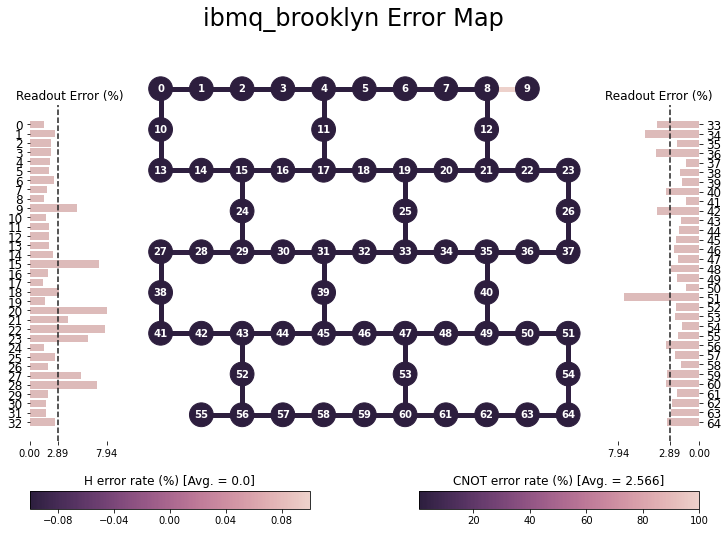

In [26]:
plot_error_map(device)

In [ ]:
from qiskit.visualization import plot_circuit_layout
from qiskit import transpile
qc_on_device = transpile(qcs[-1], backend=backend, optimization_level=1, initial_layout=vertex_list)
plot_circuit_layout(qc_on_device, backend)